In [1]:
# Git repo to clone
# git clone https://github.com/cwjng/si670-final-project.git

In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
cmr_df = pd.read_csv("si670-final-project/cancer_mortality_rates.csv")
cmr_df.head()

,cmRate,population,medianIncome,pctPoverty,avgHouse,medianAge,medianAgeM,medianAgeF,pctHS,pctBach,...,pctBlack,pctAsian,pctOther,rmRace,pctMarried,pctMarriedHouse,birthRate,region,state,county
0,191.2,25859,38013,18.6,2.28,45.4,44.6,46.2,36.4,7.9,...,4.925408,0.338357,0.065365,white,62.1,57.173258,4.687790,Southeast,Alabama,Cherokee County
1,187.9,82005,39922,17.2,2.55,40.5,39.4,41.9,34.7,9.1,...,1.190638,0.557031,0.737356,white,57.6,54.850257,3.913309,Southeast,Alabama,Cullman County
2,217.4,41131,26602,35.2,2.53,38.7,36.2,40.0,34.6,8.2,...,69.184419,0.341605,0.161313,black,33.4,30.987632,8.433257,Southeast,Alabama,Dallas County
3,193.8,81468,54298,14.4,2.65,37.9,36.7,39.1,35.4,13.4,...,21.218875,0.516326,0.678529,white,51.0,54.326202,5.800147,Southeast,Alabama,Elmore County
4,205.8,16759,35664,20.6,2.36,43.2,41.3,46.1,38.8,8.4,...,12.387547,0.390625,0.000000,white,53.6,51.499218,5.730897,Southeast,Alabama,Fayette County


In [4]:
cmr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cmRate           537 non-null    float64
 1   population       537 non-null    int64  
 2   medianIncome     537 non-null    int64  
 3   pctPoverty       537 non-null    float64
 4   avgHouse         537 non-null    float64
 5   medianAge        537 non-null    float64
 6   medianAgeM       537 non-null    float64
 7   medianAgeF       537 non-null    float64
 8   pctHS            537 non-null    float64
 9   pctBach          537 non-null    float64
 10  pctEmployed      537 non-null    float64
 11  pctUnemployed    537 non-null    float64
 12  pctPrivateHC     537 non-null    float64
 13  pctEmployerHC    537 non-null    float64
 14  pctPublicHC      537 non-null    float64
 15  pctWhite         537 non-null    float64
 16  pctBlack         537 non-null    float64
 17  pctAsian        

In [7]:
cmr_df["cmRate"].describe()

,cmRate
count,537.000000
mean,178.993110
std,27.320395
min,94.400000
25%,161.400000
50%,177.800000
75%,195.500000
max,293.900000


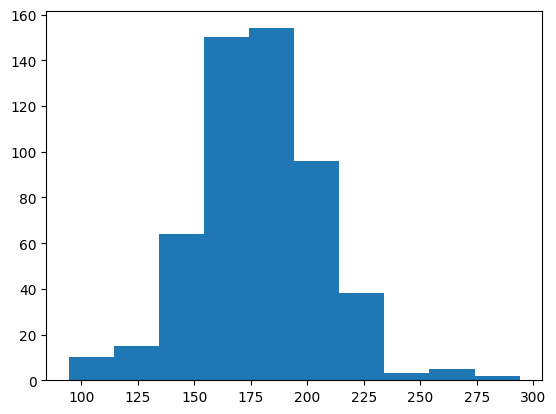

In [5]:
plt.hist(cmr_df["cmRate"]) # Normal distribution
plt.show()

In [11]:
def categorize_cmrates(rate, q1, median, q3):
  if rate < q1:
    return "Low"
  elif rate < median:
    return "Medium"
  return "High"

quartile_1 = cmr_df["cmRate"].quantile(0.25)
median = cmr_df["cmRate"].quantile(0.5)
quartile_3 = cmr_df["cmRate"].quantile(0.75)

cmr_df["cmClass"] = cmr_df["cmRate"].apply(lambda x: categorize_cmrates(x, quartile_1,
                                                                               median, quartile_3))
cmr_df.head()

,cmRate,population,medianIncome,pctPoverty,avgHouse,medianAge,medianAgeM,medianAgeF,pctHS,pctBach,...,pctOther,rmRace,pctMarried,pctMarriedHouse,birthRate,region,state,county,cmRateCategory,cmClass
0,191.2,25859,38013,18.6,2.28,45.4,44.6,46.2,36.4,7.9,...,0.065365,white,62.1,57.173258,4.687790,Southeast,Alabama,Cherokee County,High,High
1,187.9,82005,39922,17.2,2.55,40.5,39.4,41.9,34.7,9.1,...,0.737356,white,57.6,54.850257,3.913309,Southeast,Alabama,Cullman County,High,High
2,217.4,41131,26602,35.2,2.53,38.7,36.2,40.0,34.6,8.2,...,0.161313,black,33.4,30.987632,8.433257,Southeast,Alabama,Dallas County,High,High
3,193.8,81468,54298,14.4,2.65,37.9,36.7,39.1,35.4,13.4,...,0.678529,white,51.0,54.326202,5.800147,Southeast,Alabama,Elmore County,High,High
4,205.8,16759,35664,20.6,2.36,43.2,41.3,46.1,38.8,8.4,...,0.000000,white,53.6,51.499218,5.730897,Southeast,Alabama,Fayette County,High,High


In [12]:
cmr_df["cmRateCategory"].value_counts()

,count
cmRateCategory,
High,269
Medium,134
Low,134


In [13]:
X = cmr_df.drop(columns=["cmRate", "cmClass"])
y = cmr_df["cmClass"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

In [14]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

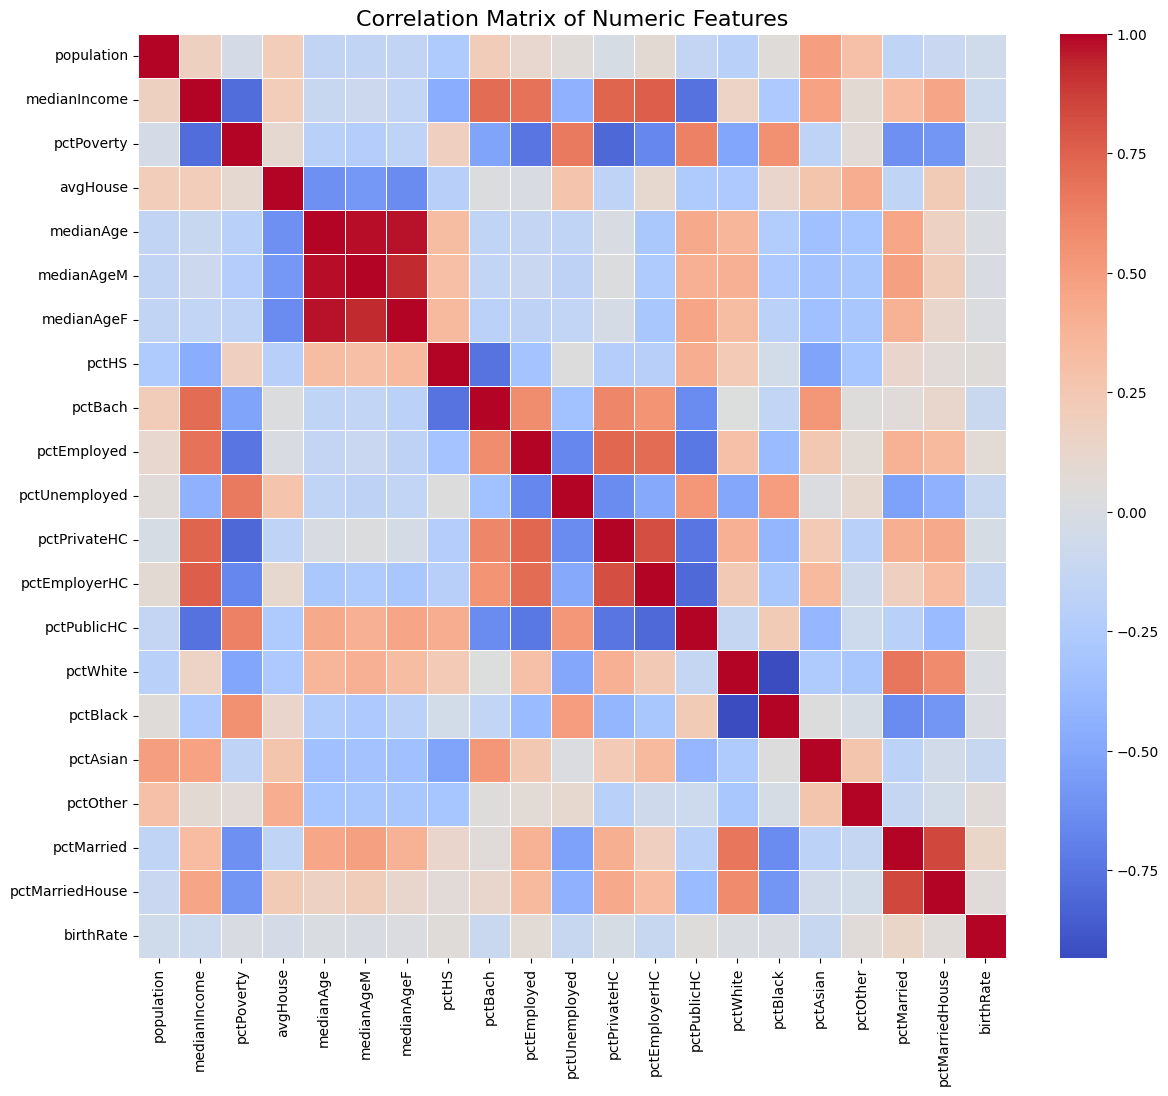

In [10]:
corr_matrix = cmr_df[num_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

In [ ]:
# sns.pairplot(cmr_df[num_cols], diag_kind="kde")
# plt.suptitle("Scatterplot Matrix of Selected Numeric Features", y=1.02, fontsize=16)
# plt.show()

In [ ]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=1.0, max_iter=5000))
])

ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

linear_r2 = r2_score(y_test, ridge_pred)
linear_rmse = mean_squared_error(y_test, ridge_pred)

print("Linear Regression:")
print("  R2:", linear_r2)
print("  RMSE:", linear_rmse)

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

rf = RandomForestRegressor(n_estimators=500, random_state=42)
X_processed = preprocess.fit_transform(X)

rf.fit(X_processed, y)

onehot_feature_names = preprocess.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, onehot_feature_names])

feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

feat_importances.head(20)